In [14]:
import numpy as np
from pyedflib import highlevel
import os

def segment_eeg(edf_file, segment_duration=120):
    """Segments the EEG data from the EDF file into 2-minute segments."""
 
    signals, header = highlevel.read_edf(edf_file)[:2]   
    sampling_rate = 512   
 
    samples_per_segment = int(segment_duration * sampling_rate)
    
    total_samples = signals.shape[1]
    
    num_segments = total_samples // samples_per_segment

    segmented_eeg = []
    
    for i in range(num_segments):
        start = i * samples_per_segment
        end = start + samples_per_segment
        segment = signals[:, start:end]
        segmented_eeg.append(segment)
     
    segmented_eeg = np.array(segmented_eeg)
 
    base_name = os.path.basename(edf_file).replace('.edf', '')
    output_file = f"{base_name}_segmented.npy"
 
    np.save(output_file, segmented_eeg)
    print(f"Segmented EEG data saved as {output_file}")

def main():
 
    edf_file = 'PN17-1.edf\PN17-1.edf'  
 
    segment_eeg(edf_file)

if __name__ == '__main__':
    main()


<>:35: SyntaxWarning: invalid escape sequence '\P'
<>:35: SyntaxWarning: invalid escape sequence '\P'
C:\Users\jpsre\AppData\Local\Temp\ipykernel_12716\770409829.py:35: SyntaxWarning: invalid escape sequence '\P'
  edf_file = 'PN17-1.edf\PN17-1.edf'


Segmented EEG data saved as PN17-1_segmented.npy


In [17]:
import numpy as np

def time_to_seconds(time_str):
    """Convert time in 'HH.MM.SS' format to seconds."""
    h, m, s = map(int, time_str.split('.'))
    return h * 3600 + m * 60 + s

def parse_text(input_text):
    """Extract time values from the given text."""
    lines = input_text.strip().split('\n')
    
    reg_start_time = lines[0].split(': ')[1].strip()
    reg_end_time = lines[1].split(': ')[1].strip()
    seizure_start_time = lines[2].split(': ')[1].strip()
    seizure_end_time = lines[3].split(': ')[1].strip()
    
    return reg_start_time, reg_end_time, seizure_start_time, seizure_end_time

def prepare_labels(reg_start_time, reg_end_time, seizure_start_time, seizure_end_time, segment_duration=120):
    """Generate labels for each 2-minute segment based on seizure events."""
 
    reg_start_sec = time_to_seconds(reg_start_time)
    reg_end_sec = time_to_seconds(reg_end_time)
    seizure_start_sec = time_to_seconds(seizure_start_time)
    seizure_end_sec = time_to_seconds(seizure_end_time)

    # Calculate total segments
    total_duration = reg_end_sec - reg_start_sec
    num_segments = int(total_duration // segment_duration)

   
    labels = []
    
    for i in range(num_segments):
        segment_start = reg_start_sec + (i * segment_duration)
        segment_end = segment_start + segment_duration
        
       
        if (segment_start < seizure_end_sec) and (segment_end > seizure_start_sec):
            labels.append(1)  
        else:
            labels.append(0)  

    return np.array(labels)

def main():
    input_text = '''Registration start time: 20.14.28
Registration end time: 22.49.05
Seizure start time: 22.34.48
Seizure end time: 22.35.58
'''
    
    reg_start_time, reg_end_time, seizure_start_time, seizure_end_time = parse_text(input_text)

    labels = prepare_labels(reg_start_time, reg_end_time, seizure_start_time, seizure_end_time)
    print(labels)
    np.save('PN17-1_labels.npy', labels)

if __name__ == '__main__':
    main()


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0]


In [3]:
import numpy as np
import pywt
import os

data_dir = r'segmented' 
transformed_dir = os.path.join(data_dir, 'transformed')
os.makedirs(transformed_dir, exist_ok=True)

for file_name in os.listdir(data_dir):
    if file_name.endswith('.npy'):
        file_path = os.path.join(data_dir, file_name)
        data = np.load(file_path)  
        transformed_data = []

        for channel_index in range(data.shape[1]): 
            original_signal = data[:, channel_index, :].flatten()  
            cA, cD = pywt.swt(original_signal, 'db4')   
            
            transformed_data.append((cA, cD))

        transformed_data_array = np.array(transformed_data, dtype=object)   

        transformed_file_path = os.path.join(transformed_dir, f'transformed_{file_name}')
        np.save(transformed_file_path, transformed_data_array)

print("Wavelet transformation complete. Transformed files saved in 'transformed' directory.")


Wavelet transformation complete. Transformed files saved in 'transformed' directory.


In [21]:
import numpy as np

def extract_pre_post_ictal(eeg_data, labels, num_pre_post=5):
    seizure_indices = np.where(labels == 1)[0]
    
    if len(seizure_indices) == 0:
        raise ValueError("No seizure events found in the labels.")

    # Select the first seizure index
    first_seizure_idx = seizure_indices[0]

    # Define start and end indices for preictal and postictal points
    start_idx = max(0, first_seizure_idx - num_pre_post)
    end_idx = min(labels.shape[0], first_seizure_idx + num_pre_post + 1)

    # Extract corresponding EEG data and labels
    selected_eeg_data = eeg_data[start_idx:end_idx]
    selected_labels = labels[start_idx:end_idx]

    # Check the shape to ensure it's (11, 35, 61440)
    assert selected_eeg_data.shape == (11, eeg_data.shape[1], eeg_data.shape[2]), \
        f"Unexpected shape: {selected_eeg_data.shape}, expected (11, 35, 61440)"

    return selected_eeg_data, selected_labels

# Example usage
eeg_data = np.load('PN17-1_segmented.npy')  # shape: (x, 35, 61440)
labels = np.load('PN17-1_labels.npy')      # shape: (x,)

selected_eeg, selected_labels = extract_pre_post_ictal(eeg_data, labels)

# Save the new arrays
np.save('selected_eeg_PN17-1.npy', selected_eeg)
np.save('selected_labels_PN17-1.npy', selected_labels)


In [2]:
import numpy as np
import pywt

# Load your EEG data from the npy file (shape: 11, 35, 61440)
eeg_data = np.load('selected_eeg_PN00-1.npy')  # Adjust the filename accordingly

# Initialize lists to store approximation and detail coefficients
approx_coeffs = []
detail_coeffs = []

# Loop through each segment (11 segments)
for segment in eeg_data:
    segment_approx = []
    segment_detail = []
    
    # Loop through each channel (35 channels per segment)
    for channel in segment:
        # Perform a single level db4 wavelet decomposition on each channel
        approx, detail = pywt.swt(channel, 'db4')
        
        # Store the approximation and detail coefficients
        segment_approx.append(approx)
        segment_detail.append(detail)
    
    # Convert to numpy arrays and append to the main list
    approx_coeffs.append(np.array(segment_approx))
    detail_coeffs.append(np.array(segment_detail))

# Convert the lists to numpy arrays
approx_coeffs = np.array(approx_coeffs)  # Shape: (11, 35, 30720)
detail_coeffs = np.array(detail_coeffs)  # Shape: (11, 35, 30720)

# Optionally, save the coefficients to npy files
np.save('approx_coeffs.npy', approx_coeffs)
np.save('detail_coeffs.npy', detail_coeffs)

# If you only need the approximation coefficients, you can now use approx_coeffs for further analysis.


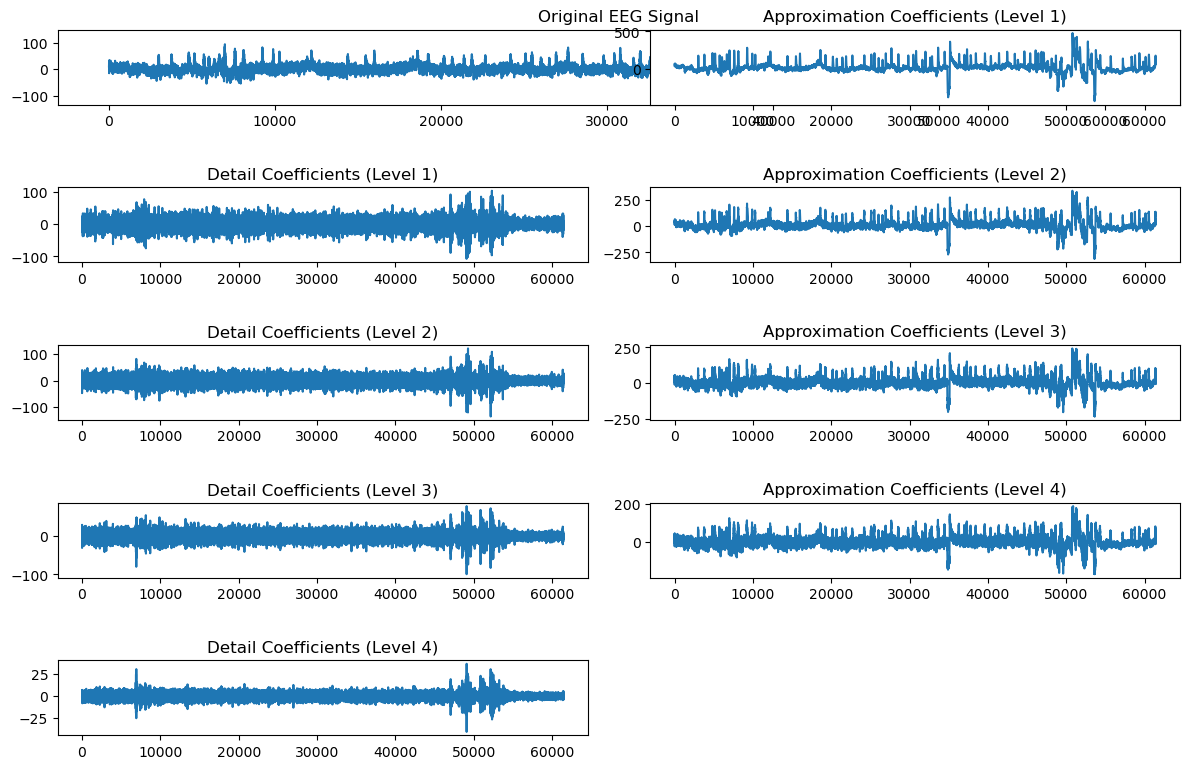

In [28]:
import numpy as np
import pywt
import matplotlib.pyplot as plt


eeg_signal = np.load('selected_eeg_PN00-1.npy')[0, 0, :]  


level = 4  
wavelet = 'db4'

coeffs = pywt.swt(eeg_signal, wavelet, level=level)
plt.figure(figsize=(12, 8))

plt.subplot(level + 1, 1, 1)
plt.plot(eeg_signal)
plt.title('Original EEG Signal')
plt.tight_layout()

for i, (approx, detail) in enumerate(coeffs, 1):
    plt.subplot(level + 1, 2, 2 * i)
    plt.plot(approx)
    plt.title(f'Approximation Coefficients (Level {i})')

    plt.subplot(level + 1, 2, 2 * i + 1)
    plt.plot(detail)
    plt.title(f'Detail Coefficients (Level {i})')

plt.tight_layout()
plt.show()


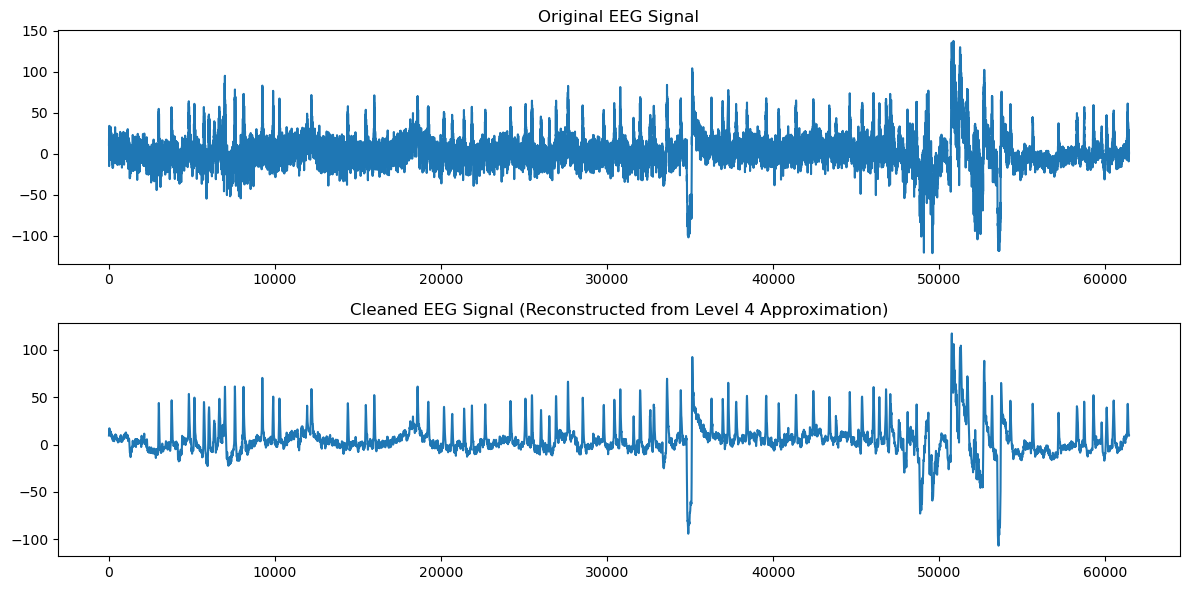

In [29]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

# Load an EEG signal (assuming one channel of shape (61440,))
eeg_signal = np.load('selected_eeg_PN00-1.npy')[0, 0, :]  # Example: use the first segment and first channel

# Perform Stationary Wavelet Transform (SWT) with 'db4' wavelet
level = 4  # Set the decomposition level
wavelet = 'db4'

# Perform SWT to get approximation and detail coefficients
coeffs = pywt.swt(eeg_signal, wavelet, level=level)

# Separate approximation and detail coefficients
# coeffs is a list of tuples (approximation, detail) for each level
approx_coeffs = [coeff[0] for coeff in coeffs]  # Get approximation coefficients
detail_coeffs = [coeff[1] for coeff in coeffs]  # Get detail coefficients

# "Cleaning" the signal by zeroing out detail coefficients at each level
# Optionally, keep some of the details if you want certain frequency bands
cleaned_detail_coeffs = [(approx_coeffs[i], np.zeros_like(detail_coeffs[i])) for i in range(level)]

# Reconstruct the signal using the modified coefficients (cleaned signal)
cleaned_signal = pywt.iswt(cleaned_detail_coeffs, wavelet)

# Plot original and cleaned signals
plt.figure(figsize=(12, 6))

# Original signal
plt.subplot(2, 1, 1)
plt.plot(eeg_signal)
plt.title('Original EEG Signal')

# Cleaned signal
plt.subplot(2, 1, 2)
plt.plot(cleaned_signal)
plt.title('Cleaned EEG Signal (Reconstructed from Level 4 Approximation)')

plt.tight_layout()
plt.show()

# Save the cleaned signal if needed
np.save('cleaned_eeg_signal.npy', cleaned_signal)


In [30]:
np.load('selected_labels_PN00-1.npy')

array([0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0])

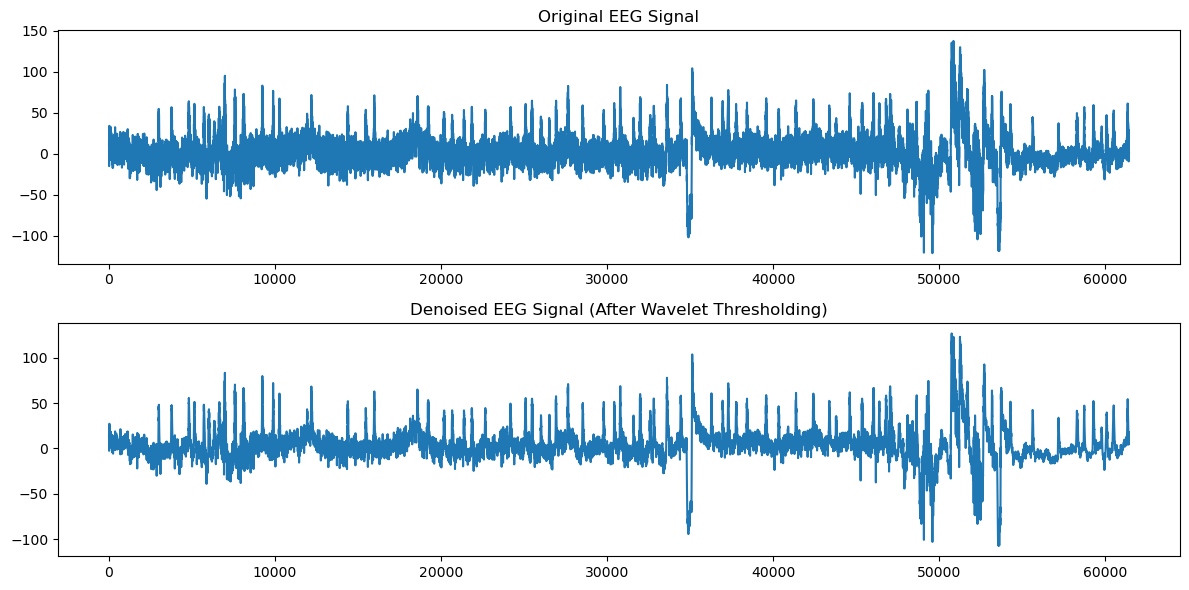

In [34]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

# Load an EEG signal (assuming one channel of shape (61440,))
eeg_signal = np.load('selected_eeg_PN00-1.npy')[0, 0, :]  # Example: use the first segment and first channel

# Perform Discrete Wavelet Transform (DWT) with 'db4' wavelet at level 4
wavelet = 'db4'
level = 4

# Perform multi-level DWT
coeffs = pywt.wavedec(eeg_signal, wavelet, level=level)

# Set a universal threshold (VisuShrink method)
# Threshold can be computed as sigma * sqrt(2 * log(n)), where sigma is the noise standard deviation
# Here, we use an empirical approach by estimating the noise level from the detail coefficients at the last level
detail_coeffs_last_level = coeffs[-1]
sigma = np.median(np.abs(detail_coeffs_last_level)) / 0.6745  # Median absolute deviation (MAD) estimator of noise
threshold = sigma * np.sqrt(2 * np.log(len(eeg_signal)))

# Apply soft thresholding to the detail coefficients
def soft_thresholding(coeffs, threshold):
    return np.sign(coeffs) * np.maximum(np.abs(coeffs) - threshold, 0)

# Apply thresholding to all detail coefficients (coeffs[1:] contains detail coefficients)
cleaned_coeffs = [coeffs[0]]  # Keep approximation coefficients unchanged
for detail in coeffs[1:]:
    cleaned_coeffs.append(soft_thresholding(detail, threshold))

# Reconstruct the signal using the thresholded coefficients
denoised_signal = pywt.waverec(cleaned_coeffs, wavelet)

# Plot original and denoised signals
plt.figure(figsize=(12, 6))

# Original signal
plt.subplot(2, 1, 1)
plt.plot(eeg_signal)
plt.title('Original EEG Signal')

# Denoised signal (reconstructed after thresholding)
plt.subplot(2, 1, 2)
plt.plot(denoised_signal)
plt.title('Denoised EEG Signal (After Wavelet Thresholding)')

plt.tight_layout()
plt.show()

# Save the denoised signal if needed
np.save('denoised_eeg_signal.npy', denoised_signal)


**Arrange Channels**

In [8]:
import numpy as np
fname = r'selected_eeg_PN09-1.npy'
# Load your npy file
data = np.load(fname)  # Shape (n, 10, x)

# Define the original and new indices for the row to be moved
old_index = 17  # e.g., moving the 9th row (index 8 in 0-based indexing)
new_index = 34 # e.g., moving it to the 3rd position (index 2 in 0-based indexing)

old_index -= 1
new_index -= 1
# Create a new array with the adjusted rows
# Use list comprehension to apply the row movement to each sample
data_reordered = np.array([
    np.insert(np.delete(sample, old_index, axis=0), new_index, sample[old_index], axis=0)
    for sample in data
])

# Save the modified array back to a new npy file
np.save(fname, data_reordered)


**Stack Data**

In [4]:
import numpy as np
import os

In [5]:
a = np.load('segmented\PN00-1_segmented.npy')
for i in os.listdir('segmented'):

    if i.endswith('.npy'):
        b = np.load(os.path.join('segmented', i))
        a = np.concatenate((a, b), axis=0)
np.save('final_untransformed_data', a)
np.load('final_untransformed_data.npy').shape

<>:1: SyntaxWarning: invalid escape sequence '\P'
<>:1: SyntaxWarning: invalid escape sequence '\P'
C:\Users\jpsre\AppData\Local\Temp\ipykernel_24264\2009312425.py:1: SyntaxWarning: invalid escape sequence '\P'
  a = np.load('segmented\PN00-1_segmented.npy')


(710, 35, 61440)

In [5]:
np.load('selected_eeg_PN03-1.npy').shape

(11, 35, 61440)

**Stack Labels**

In [89]:
a = np.load('labels\PN00-1_labels.npy')
for i in os.listdir('labels'):

    if i.endswith('.npy'):
        b = np.load(os.path.join('labels', i))
        for j in range(b.shape[0]):
                if b[j] == 0:
                     b[j] = 1
                else:
                     break
        a = np.concatenate((a, b), axis=0)
np.save('final_untransformed_labels.npy', a)

<>:1: SyntaxWarning: invalid escape sequence '\P'
<>:1: SyntaxWarning: invalid escape sequence '\P'
C:\Users\jpsre\AppData\Local\Temp\ipykernel_67144\3510419493.py:1: SyntaxWarning: invalid escape sequence '\P'
  a = np.load('labels\PN00-1_labels.npy')


In [86]:
a.shape

(710,)

In [80]:
np.array([1,2,4]).shape[0]

3

In [4]:
import numpy as np
import pywt

data = np.load('selected_channels.npy')  
wavelet = 'db4'
level = 2 
transformed_data = np.zeros_like(data)

 
for i in range(data.shape[0]):        
    for j in range(data.shape[1]):     
         
        coeffs = pywt.swt(data[i, j, :], wavelet, level=level, trim_approx=True)
        transformed_data[i, j, :] = pywt.iswt(coeffs, wavelet)
np.save('final_transformed_data.npy', transformed_data)


In [6]:
data = np.load('final_transformed_data.npy').shape


(819, 13, 61440)

In [ ]:
import numpy as np
import pywt

data = np.load('selected_channels.npy')
wavelet = 'db4'
level = 2
transformed_data = np.zeros_like(data)

def soft_threshold(coeff, threshold):
    return np.sign(coeff) * np.maximum(np.abs(coeff) - threshold, 0)

for i in range(data.shape[0]):  
    for j in range(data.shape[1]): 
        coeffs = pywt.swt(data[i, j, :], wavelet, level=level, trim_approx=True)
        
        for k in range(1, len(coeffs)): 
            detail_coeff = coeffs[k][1]
            
            if isinstance(detail_coeff, np.ndarray) and len(detail_coeff) > 1:
                threshold = np.sqrt(2 * np.log(len(detail_coeff))) * np.median(np.abs(detail_coeff)) / 0.6745
                coeffs[k] = (coeffs[k][0], soft_threshold(detail_coeff, threshold))
            else:
                coeffs[k] = (coeffs[k][0], detail_coeff)
        
        transformed_data[i, j, :] = pywt.iswt(coeffs, wavelet)

np.save('final_transformed_data.npy', transformed_data)


In [91]:
np.load('final_transformed_data.npy').shape

(710, 35, 61440)

In [1]:
import numpy as np

# Your numpy array
arr = np.array([1, 2, 3, 4, 5, 0, 0, 0, 0, 0])

# Find the index of the last non-zero element
last_non_zero_idx = np.max(np.nonzero(arr))

# Calculate the start and end indices for slicing
start_idx = max(0, last_non_zero_idx - 3)
end_idx = min(len(arr), last_non_zero_idx + 4)

# Slice the array to get the required elements
result = arr[start_idx:end_idx]

print("Result:", result)


Result: [2 3 4 5 0 0 0]


In [ ]:
arr_3d = np.load('final_transformed_data.npy')

In [4]:
import numpy as np
import os

# Assuming the 1D label arrays are in a directory called 'labels_dir'
# and the 3D array is a single file like 'data_3d.npy'
labels_dir = 'labels'  # Path to the directory containing 1D label files
threed_file_path = 'final_transformed_data.npy'     # Path to the 3D data file

# Load the 3D data array
arr_3d = np.load(threed_file_path)

# Initialize lists to store the results
new_labels = []
extracted_3d_points = []

# Loop over all files in the labels directory (assuming they are numpy label files)
for label_file in os.listdir(labels_dir):
    if label_file.endswith('.npy'):  # Ensure the file is a .npy file
        label_path = os.path.join(labels_dir, label_file)
        
        # Load the 1D label array
        arr_1d = np.load(label_path)
        
        # Find the index of the last non-zero element in the 1D array
        last_non_zero_idx = np.max(np.nonzero(arr_1d))
        
        # Calculate start and end indices to extract up to 5 points
        start_idx = max(0, last_non_zero_idx - 4)  # Adjust to get 10 points if possible
        end_idx = min(len(arr_1d), last_non_zero_idx + 5)
        
        # Extract the 1D label slice
        extracted_1d = arr_1d[start_idx:end_idx]
        new_labels.append(extracted_1d)
        
        # Extract the corresponding slice from the 3D array
        extracted_3d = arr_3d[start_idx:end_idx, :, :]
        extracted_3d_points.append(extracted_3d)

# Save the new labels and extracted 3D points to separate files
new_labels = np.array(new_labels, dtype=object)  # Convert to object array for varying lengths
extracted_3d_points = np.array(extracted_3d_points, dtype=object)

# Save to files
np.save('new_labels.npy', new_labels)  # Save all new labels into a file
np.save('extracted_3d_points.npy', extracted_3d_points)  # Save all extracted 3D points into a file

print("Processing completed. New labels and extracted 3D points have been saved.")


Processing completed. New labels and extracted 3D points have been saved.


In [13]:
extraacted = np.load('extracted_3d_points.npy', allow_pickle=True)

In [15]:
el = np.load('new_labels.npy', allow_pickle=True)

In [14]:
np.save(r'C:\SEM-5\Bio\final\extracted\3d_points', np.reshape(extraacted, (13*9, 35, 61440)))

In [16]:
np.save(r'C:\SEM-5\Bio\final\extracted\labels', np.reshape(el, (13*9)))

In [24]:
np.load('selected_eeg_PN16-1.npy').shape

(11, 49, 61440)

In [5]:
import numpy as np

In [5]:
x = np.load('final_data.npy')
y = np.load('fina_labels.npy')

In [6]:
x.shape

(819, 35, 61440)

In [ ]:
import numpy as np
np.std

In [7]:
d = np.load('final_untransformed_data.npy')

In [5]:
y = np.load('final_untransformed_labels.npy')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

# Assuming 'x' has shape (n_samples, n_channels, n_timepoints)
# Flatten the 3D data (samples x channels * timepoints)

X_flat = x.reshape(x.shape[0], -1)  # Flatten the data across channels and timepoints

# Train the RandomForest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_flat, y)

# Permutation importance calculation
result = permutation_importance(model, X_flat, y, n_repeats=10, random_state=42)

# Extract importance scores
importances = result.importances_mean
sorted_idx = np.argsort(importances)[::-1]  # Sort indices of features by importance

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_idx)), importances[sorted_idx], color='skyblue')
plt.xticks(range(len(sorted_idx)), [f'Channel {i+1}' for i in sorted_idx], rotation=90)
plt.xlabel('EEG Channels')
plt.ylabel('Importance Score')
plt.title('EEG Channel Importance using Random Forest')
plt.show()

# Get the top 13 most important channels
top_n_channels = sorted_idx[:13]
print("Top 13 important channels:", top_n_channels)


In [10]:
top_n_channels

array([26, 29, 34, 14,  8, 16, 22, 15, 25, 27,  0, 24,  9], dtype=int64)

In [12]:
import numpy as np

# Sample 3D array of shape (x, y, z)
arr = np.load('final_data.npy')

# 1D array of indices (e.g., indices along the y-axis)
indices = top_n_channels

# Check if indices are valid and exist within the range of y-dimension
valid_indices = indices[indices < arr.shape[1]]

# Use the valid indices to select slices from the 3D array
selected_slices = arr[:, valid_indices, :]

print("Selected slices shape:", selected_slices.shape)


Selected slices shape: (819, 13, 61440)


In [13]:
np.save('selected_channels.npy', selected_slices)

In [ ]:
import mne
import numpy as np
from datetime import datetime, timedelta
import os

def parse_seizure_list(file_path):
    """
    Parse seizure details for multiple EDF files from the formatted text file.
    Args:
        file_path (str): Path to the seizure list file.
    Returns:
        dict: Dictionary where keys are EDF file names and values are dicts containing
              registration start time, end time, and a list of seizure intervals.
    """
    seizure_data = {}
    current_file = None
    registration_start = None
    seizures = []

    with open(file_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            line = line.strip()
            if line.startswith("File name:"):
                if current_file:
                    # Store the current file's data before processing the next file
                    seizure_data[current_file] = {
                        "registration_start": registration_start,
                        "seizures": seizures,
                    }
                # Reset for the new file
                current_file = line.split(": ", 1)[1].strip()
                seizures = []
            elif line.startswith("Registration start time:"):
                registration_start = line.split(": ", 1)[1].strip()
            elif line.startswith("Seizure start time:"):
                seizure_start = line.split(": ", 1)[1].strip()
            elif line.startswith("Seizure end time:"):
                seizure_end = line.split(": ", 1)[1].strip()
                seizures.append((seizure_start, seizure_end))
        
        # Add the last file's data
        if current_file:
            seizure_data[current_file] = {
                "registration_start": registration_start,
                "seizures": seizures,
            }
    
    return seizure_data

def prepare_labels(edf_file, registration_start, seizures, segment_duration=120):
    """
    Segment the EEG data and prepare seizure labels for a single EDF file.
    Args:
        edf_file (str): Path to the EDF file.
        registration_start (str): Start time of the recording in HH.MM.SS format.
        seizures (list of tuples): List of seizure intervals (start, end) in HH.MM.SS format.
        segment_duration (int): Duration of each segment in seconds.
    Returns:
        np.ndarray: Segmented EEG data.
        np.ndarray: Labels for each segment.
    """
    # Load EEG data
    raw = mne.io.read_raw_edf(edf_file, preload=True)
    sfreq = int(raw.info['sfreq'])  # Sampling frequency
    data = raw.get_data()

    # Convert registration start time to datetime
    start_datetime = datetime.strptime(registration_start, "%H.%M.%S")
    
    # Convert seizure times to datetime
    seizure_intervals = [
        (datetime.strptime(start, "%H.%M.%S"), datetime.strptime(end, "%H.%M.%S"))
        for start, end in seizures
    ]
    
    # Segment data and create labels
    segment_samples = segment_duration * sfreq
    n_segments = data.shape[1] // segment_samples
    segments = []
    labels = []
    
    for i in range(n_segments):
        segment_start = start_datetime + timedelta(seconds=i * segment_duration)
        segment_end = segment_start + timedelta(seconds=segment_duration)
        segment = data[:, i * segment_samples:(i + 1) * segment_samples]
        label = 0
        for seizure_start, seizure_end in seizure_intervals:
            if seizure_start <= segment_end and seizure_end >= segment_start:
                label = 1
                break
        segments.append(segment)
        labels.append(label)
    
    return np.array(segments), np.array(labels)

def process_files(file_dir, seizure_list_file, output_dir, segment_duration=120):
    """
    Process EDF files based on seizure list information.
    Args:
        file_dir (str): Directory containing the EDF files.
        seizure_list_file (str): Path to the seizure list file.
        output_dir (str): Directory to save segmented data and labels.
        segment_duration (int): Duration of each segment in seconds.
    """
    seizure_data = parse_seizure_list(seizure_list_file)
    
    for edf_file, details in seizure_data.items():
        edf_path = os.path.join(file_dir, edf_file)  # Full path to EDF file
        if os.path.exists(edf_path):
            print(f"Processing {edf_file}...")
            segments, labels = prepare_labels(
                edf_path, 
                details["registration_start"], 
                details["seizures"],
                segment_duration=segment_duration
            )
            
            # Save segments and labels
            base_name = os.path.splitext(edf_file)[0]  # Remove extension
            np.save(os.path.join(output_dir, f"{base_name}_segments.npy"), segments)
            np.save(os.path.join(output_dir, f"{base_name}_labels.npy"), labels)
        else:
            print(f"File {edf_file} not found. Skipping...")

file_dir = "/content/epilepsy_dataset/siena-scalp-eeg-database-1.0.0/PN00"  # Directory containing EDF files
seizure_list_file = "/content/epilepsy_dataset/siena-scalp-eeg-database-1.0.0/PN00/Seizures-list-PN00.txt"  # Path to seizure list file
output_dir = "./output"  # Directory to save outputs
os.makedirs(output_dir, exist_ok=True)

process_files(file_dir, seizure_list_file, output_dir, segment_duration=120)